In [16]:
import torch
from torch import nn
from d2l import torch as d2l
import torchvision
from torchvision import transforms


In [3]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

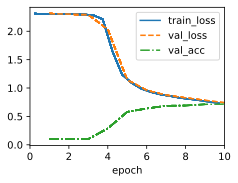

In [4]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### 1. Let’s modernize LeNet. Implement and test the following changes:

1. Replace average pooling with max-pooling.
1. Replace the softmax layer with ReLU.

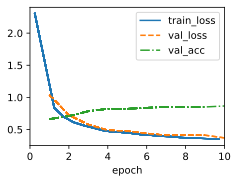

In [5]:
class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [11]:
Y = data.val.targets
Y_hat = model(data.val.data.to('cuda').type(torch.float32).unsqueeze(dim=1)).to('cpu')
model.accuracy(Y_hat, Y)

tensor(0.8491)

### 2. Try to change the size of the LeNet style network to improve its accuracy in addition to max-pooling and ReLU.

1. Adjust the convolution window size.
1. Adjust the number of output channels.
1. Adjust the number of convolution layers.
1. Adjust the number of fully connected layers.
1. Adjust the learning rates and other training details (e.g., initialization and number of epochs).

tensor(0.8517)

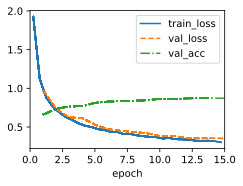

In [15]:
class LeNetImproved(d2l.Classifier):  #@save
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(16, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(32, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(64), nn.Sigmoid(),
            nn.LazyLinear(32), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

model = LeNetImproved(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
trainer.fit(model, data)

Y = data.val.targets
Y_hat = model(data.val.data.to('cuda').type(torch.float32).unsqueeze(dim=1)).to('cpu')
model.accuracy(Y_hat, Y)

### 3. Try out the improved network on the original MNIST dataset.

tensor(0.9856)

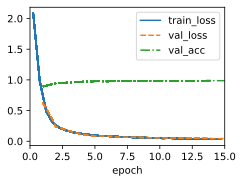

In [18]:
class MNIST(d2l.FashionMNIST):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.MNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)

mnist_data = MNIST(batch_size=128)

model = LeNetImproved(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
trainer.fit(model, mnist_data)

Y = mnist_data.val.targets
Y_hat = model(mnist_data.val.data.to('cuda').type(torch.float32).unsqueeze(dim=1)).to('cpu')
model.accuracy(Y_hat, Y)

### 4. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).

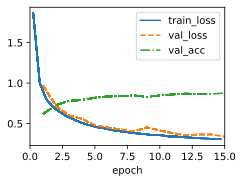

In [34]:
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
trainer.fit(model, data)

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'pullover'}>], dtype=object)

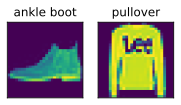

In [48]:
X = data.val.data[:2]
Y = data.val.targets[:2]
labels = data.text_labels(Y)
d2l.show_images(X.squeeze(1), 1, 2, titles=labels)

The first activation layer output:

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

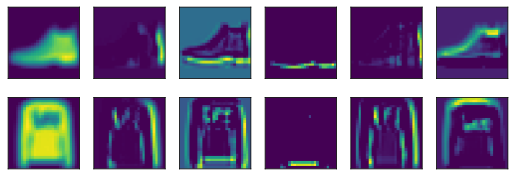

In [40]:
pics = model.net[:2](X.to('cuda')).squeeze().detach().to('cpu').numpy().reshape(-1,28,28)
d2l.show_images(pics, 2, 6)

The second activation layer output:

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

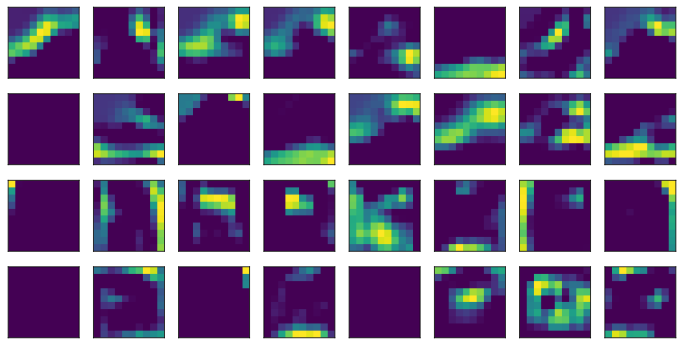

In [42]:
pics = model.net[:5](X.to('cuda')).squeeze().detach().to('cpu').numpy().reshape(-1, 10, 10)
d2l.show_images(pics, 4, 8)
# the first two rows are activations of sneaker
# the last two rows are activations of pullover

### 5. What happens to the activations when you feed significantly different images into the network (e.g., cats, cars, or even random noise)?

array([<Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>], dtype=object)

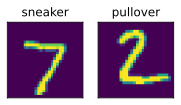

In [49]:
X = mnist_data.val.data[:2]
Y = mnist_data.val.targets[:2]
labels = data.text_labels(Y)
d2l.show_images(X.squeeze(1), 1, 2, titles=labels)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

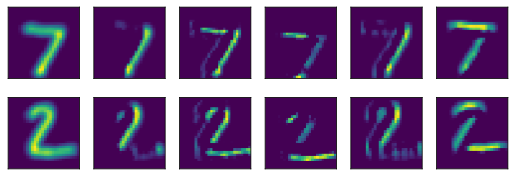

In [52]:
pics = model.net[:2](X.type(torch.float).to('cuda').unsqueeze(dim=1)).squeeze().detach().to('cpu').numpy().reshape(-1,28,28)
d2l.show_images(pics, 2, 6)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

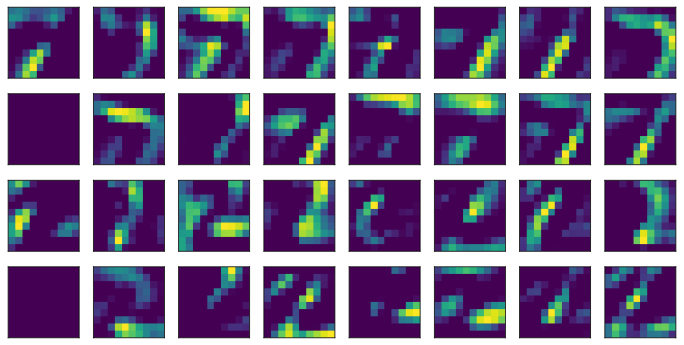

In [53]:
pics = model.net[:5](X.type(torch.float).to('cuda').unsqueeze(dim=1)).squeeze().detach().to('cpu').numpy().reshape(-1, 10, 10)
d2l.show_images(pics, 4, 8)

It can still capture some features of the new input.